In [1]:
import os
import functools

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import cv2

import dataset_configs
import data_io
import u_net

import tensorflow as tf
from tensorflow.keras import models, layers, losses

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

tf.__version__

'2.0.0-alpha0'

# Set up

In [ ]:
task = 'incucyte_nucleus'
test_size = 0.2
random_state = 423

data_cfg = dataset_configs.get_dataset_config(task)
data_cfg['match_pattern'] = '_[A-Z]4_'

x_train_fnames, x_val_fnames, y_train_fnames, y_val_fnames = \
    data_io.get_data_filenames(**data_cfg, test_size=test_size, random_state=random_state)

num_train_data = len(x_train_fnames)
num_val_data = len(x_val_fnames)

for k in data_cfg:
    print(k, ':', data_cfg[k])
print()
print("Number of training samples: {}".format(num_train_data))
print("Number of validation samples: {}".format(num_val_data))

In [ ]:
idx = np.random.choice(num_val_data)
print(os.path.basename(x_val_fnames[idx]))
print(os.path.basename(y_val_fnames[idx]))

In [ ]:
import re

pattern = re.compile('_(?P<well>[A-Z]\d+)_')

wells = [pattern.search(os.path.basename(f)).group('well') for f in x_train_fnames]

print(len(set(wells)))
print(sorted(list(set(wells))))

# Test the input pipeline

In [ ]:
read_img_fn = functools.partial(data_io._get_image_from_path, channels=data_cfg['n_channels'], 
                                dtype=data_cfg['dtype'], crop_bd_width=data_cfg['crop_bd_width'])
tmp_ds = data_io.get_dataset(x_train_fnames, y_train_fnames, read_img_fn=read_img_fn)

plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(tmp_ds.shuffle(num_train_data).take(3)):
    print(img.numpy().max())
    print(mask.numpy().max())
    print(img.shape)
    plt.subplot(3,2,2*i+1)
    plt.imshow(img[0,:,:,0]/255., cmap='gray')
    plt.subplot(3,2,2*i+2)
    plt.imshow(mask[0,:,:,0]/255., cmap='binary')
plt.show()

# Configure training and validation datasets

In [ ]:
read_img_fn = functools.partial(data_io._get_image_from_path, channels=data_cfg['n_channels'], 
                                dtype=data_cfg['dtype'], crop_bd_width=data_cfg['crop_bd_width'])

batch_size = data_cfg['batch_size']
# batch_size = 6

# training data
train_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512],
    'to_flip': True
}
tr_preproc_fn = functools.partial(data_io._augment, **train_cfg)

# validation data
val_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512]
}
val_preproc_fn = functools.partial(data_io._augment, **val_cfg)

train_ds = data_io.get_dataset(x_train_fnames, y_train_fnames, read_img_fn=read_img_fn,
                               preproc_fn=tr_preproc_fn, shuffle=True, batch_size=batch_size)
val_ds = data_io.get_dataset(x_val_fnames, y_val_fnames, read_img_fn=read_img_fn, 
                             preproc_fn=val_preproc_fn, shuffle=False, batch_size=batch_size)

In [ ]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(val_ds.take(3)):
    print(img.shape)

    print(img.numpy().min(), img.numpy().max())
    print(mask.numpy().min(), mask.numpy().max())
    
    plt.subplot(3,3,3*i+1)
    plt.imshow(img[0,:,:,0])
    
    plt.subplot(3,3,3*i+2)
    plt.imshow(mask[0,:,:,0])
    
    
    
#     plt.subplot(3,3,3*i+3)
#     plt.imshow(mask[0,:,:,1])

# Customized loss

In [ ]:
for img, mask in val_ds.shuffle(num_val_data).take(1):
    idx = 0
    
    w_cfg = {
        'nuc_ch': 1,
        'cell_ch': 0,
        'w0': 5,
        'sigma': 3
    }
    
    y_pred = model(img)
    
    loss, cb, nuc_dw, cell_dw = u_net.weighted_cce_loss(mask, y_pred, **w_cfg)
    print(tf.reduce_max(cb, axis=(1,2)))
    
    print(loss.shape)
    print(cb.shape)
    print(nuc_dw.shape)
    print(cell_dw.shape)
    
    L = loss[idx].numpy()
    CB = cb[idx].numpy()
    b = np.zeros_like(mask[idx,...,0])
    NW = nuc_dw[idx].numpy()
    CW = cell_dw[idx].numpy()
    
#     CB = CB / CB.max()
#     NW = NW / np.median(NW)
#     CW = CW / np.median(CW)
    
    plt.figure(figsize=(16,16))
    plt.subplot(2,2,1)
    plt.imshow(np.dstack([NW/NW.max(), mask[idx,...,w_cfg['nuc_ch']], b]))
    
    plt.subplot(2,2,2)
    plt.imshow(np.dstack([CW/CW.max(), mask[idx,...,w_cfg['cell_ch']], b]))
    
    plt.subplot(2,2,3)
    plt.imshow(np.dstack([L, mask[idx,...,w_cfg['cell_ch']], b]))
    
    print([CB.min(), CB.mean(), CB.max()])
    print([NW.min(), NW.mean(), NW.max()])
    print([CW.min(), CW.mean(), CW.max()])
    print([L.min(), L.mean(), L.max()])
    
#     plt.subplot(2,2,3)
#     plt.hist(NW, bins='auto')
    
#     plt.subplot(2,2,4)
#     plt.hist(CW, bins='auto')
    

In [ ]:
import importlib
importlib.reload(u_net)

In [ ]:
%matplotlib notebook

for (img, mask) in val_ds.shuffle(num_val_data).take(1):
    print(mask.dtype)
#     L = u_net.weighted_loss(mask, mask)
    M = mask[0,:,:,0]
    wc = u_net.balancing_weight_tf(M)
    dw = u_net.distance_weight(M.numpy(), w0=5, sigma=5.0)
    W = u_net.get_pixel_weights(mask[0], w0=5, sigma=5.0)
    
    plt.figure(figsize=(10,12))
    b = np.zeros_like(M)
    plt.imshow(np.dstack([W/W.numpy().max(), M, b]))
#     plt.imshow(dw)
    
#     plt.subplot(1,3,1)
#     plt.imshow(img[0,:,:,0])

#     plt.subplot(1,3,2)
#     plt.imshow(M)

#     plt.subplot(1,3,3)
#     plt.imshow(dw)
    
#     print(L.shape)
    print((wc.numpy().min(), wc.numpy().max()))
    print((dw.min(), dw.max()))
    print(wc.numpy().sum(), dw.sum())
    
#     plt.figure(figsize=(12,16))
    
#     for i, w in enumerate(L):
#         if i>2:
#             break
            
#         plt.subplot(3,3,3*i+1)
#         plt.imshow(img[i,:,:,0])

#         plt.subplot(3,3,3*i+2)
#         plt.imshow(mask[i,:,:,0])

#         plt.subplot(3,3,3*i+3)
#         plt.imshow(w)
#         print((w.numpy().min(), w.numpy().max()))
        


# Build the model

In [2]:
num_filters_list = [32, 64, 128, 256, 512]
n_classes = 2

w_cfg = {
    'nuc_ch': 1,
    'cell_ch': 0,
    'w0': 5,
    'sigma': 3
}

model = u_net.Unet(num_filters_list, n_classes=n_classes, dynamic=True)

# loss_fn = functools.partial(u_net.weighted_bce_loss, w0=w_cfg['w0'], sigma=w_cfg['sigma'])
# loss_fn = functools.partial(u_net.weighted_bce_dice_loss, w0=w_cfg['w0'], sigma=w_cfg['sigma'])
loss_fn = losses.binary_crossentropy
# loss_fn = functools.partial(u_net.weighted_cce_loss, **w_cfg)

model.compile(optimizer='adam', loss=loss_fn, metrics=[])

In [ ]:
y = model(tf.random.uniform([1, 512, 512, 1]))
print(y.shape)
plt.imshow(y[0,...,0])

## Train the model

In [ ]:
root_path = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation'
model_tag = 'incucyte_nuc_weighted_bce_dice_test_'

timestamp = '{}'.format(datetime.datetime.now()).split('.')[0].replace('-','').replace(':','-').replace(' ','_')
foler_name = model_tag + timestamp

# model weights
weights_path = os.path.join(root_path, 'models', foler_name, 'weights-{epoch:04d}.ckpt')
weights_dir = os.path.dirname(weights_path)
if not os.path.isdir(weights_dir):
    os.makedirs(weights_dir, exist_ok=True)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, monitor='val_dice_loss', 
                                        save_best_only=True, save_weights_only=True, verbose=1)
# tensorboard
log_dir = os.path.join(root_path, 'logs', foler_name)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir, exist_ok=True)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
history = model.fit(train_ds, epochs=50, 
                    steps_per_epoch=int(np.ceil(num_train_data / batch_size)),
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_data / batch_size)),
                    callbacks=[cp, tb])

### Plot training process

In [ ]:
tr_process = pd.DataFrame.from_dict(history.history)
tr_process['epoch'] = np.array(range(1, tr_process.shape[0]+1))

tr_process.plot(x='epoch', y=['loss', 'val_loss'])
# tr_process.plot(x='epoch', y=['dice_loss', 'val_dice_loss'])

### Or load the trained weights

In [4]:
model_dir = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/models/incucyte_nuc_weighted_bce_dice_20190424_16-09-32'
latest = tf.train.latest_checkpoint(model_dir)
print(latest)
model.load_weights(latest)

/awlab/users/chsu/WorkSpace/tensorflow/segmentation/models/incucyte_nuc_weighted_bce_dice_20190424_16-09-32/weights-0014.ckpt


In [ ]:
model.evaluate(val_ds, steps=int(np.ceil(num_val_data / batch_size)))

# Visualize performance

### Test on validation dataset

In [ ]:
idx_to_plot = np.random.choice(num_val_data, 3)
result_folder = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/results/incucyte_nuc_weighted'
nuc_idx = 1
cell_idx = 0

if not os.path.isdir(result_folder):
    os.makedirs(result_folder)

# plt.figure(figsize=(12,16))

for i, (img, mask) in enumerate(val_ds):
    if i in idx_to_plot:
        y_pred = model(img)        
        for j in range(4):
            I = np.uint8(img[j].numpy()*255.)
            M = np.uint8(mask[j].numpy()*255.) 
            M_pred = np.uint8((y_pred[j].numpy() > 0.5) *255.)
            
            if task == 'both_seg':
                I = np.uint8(img[j].numpy()*255.)
                M = np.uint8(mask[j].numpy()*255.) 
                M_pred = np.uint8((y_pred[j].numpy() > 0.5) *255.)
                
                # overlay nucleus segmentation
                I = data_io.overlay_mask(I, M[:,:,nuc_idx], M_pred[:,:,nuc_idx], 
                                 true_color=None, pred_color=(0,255,255))
                # overlay cell segmentation
                I = data_io.overlay_mask(I, M[:,:,cell_idx], M_pred[:,:,cell_idx], 
                                 true_color=None, pred_color=(255,0,255))
            else:
                I = data_io.overlay_mask(I, M[:,:,0], M_pred[:,:,0])
            
            fname = os.path.join(result_folder, '{}_{}.png'.format(i,j))
            cv2.imwrite(fname, cv2.cvtColor(I, cv2.COLOR_RGB2BGR))
            
#             plt.subplot(2,2,j+1)
#             plt.imshow(I)
            
    if i > max(idx_to_plot):
        break

### Test on new data (numpy format)

In [35]:
file_dir = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/2019028023_PC9_A549_with_nuclear_marker/images'
file_type = '*.png'
filter_patter = '_A2_'
img_files = data_io.get_filenames(file_dir, file_type, filter_patter)

print(len(img_files))
print(img_files[:3])

52
['/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/2019028023_PC9_A549_with_nuclear_marker/images/phase_A2_1_00d00h00m.png', '/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/2019028023_PC9_A549_with_nuclear_marker/images/phase_A2_1_00d02h00m.png', '/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/2019028023_PC9_A549_with_nuclear_marker/images/phase_A2_1_00d04h00m.png']


In [ ]:
model.predict()

In [ ]:
def get_test_dataset(file_dir, file_type, filter_pattern):
    img_files = data_io.get_filenames(file_dir, file_type, filter_patter)
    

<IPython.core.display.Javascript object>


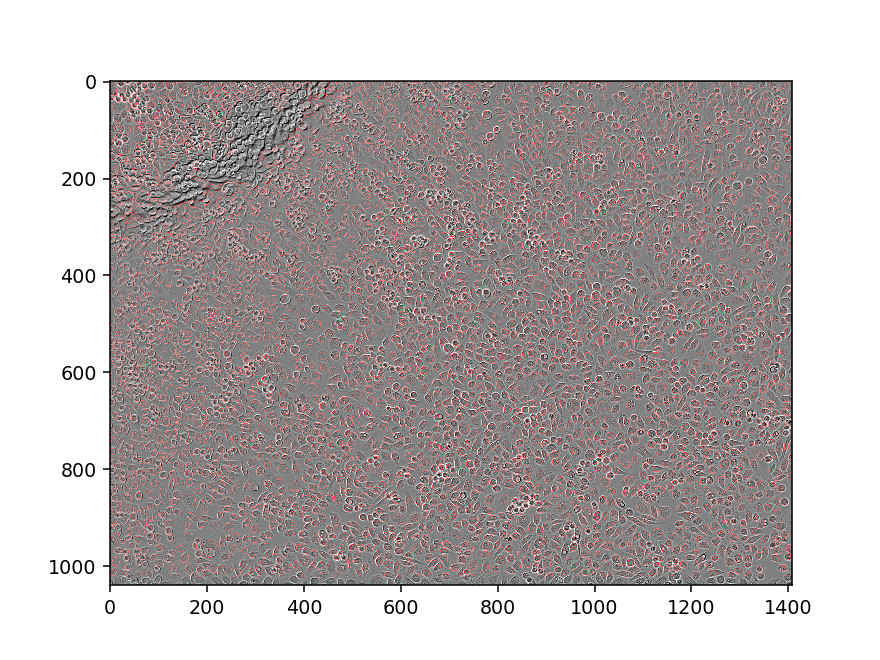

In [41]:
%matplotlib notebook

f = img_files[0]

img = tf.image.decode_png(tf.io.read_file(f), channels=1, dtype='uint8')
img = tf.cast(img, tf.float32) / 255.
img = tf.expand_dims(img, axis=0)

y_pred = model(img[:1024, :1024])

I = I = np.uint8(img[0]*255.)
M_pred = np.uint8((y_pred[0,...,0].numpy() > 0.5) * 255.)

I = data_io.overlay_mask(I, [], M_pred, true_color=None, pred_color=(255,0,0))

plt.imshow(I)